In [6]:
import os
import json
import csv
import configparser

import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import colors

from scipy.spatial.transform import Rotation

import traceback
import logging

logger = logging.getLogger('arc.'+__name__)

# Environment

In [7]:
def list_dirs(data_path):
    items = [ (f.path, f.name) for f in os.scandir(data_path) if f.is_dir()]
    for dirname, name in items:
        logger.info(dirname)
    return items

In [8]:
data_dir  = 'data'
tasks = {}
paths = {}

data_path           = Path( data_dir + '/abstraction-and-reasoning-challenge/')
dirs = list_dirs(data_path)

for path, name in dirs:
    paths[name]   = path
    tasks[name]   = sorted(os.listdir(paths[name]))

print(dirs)
for v in tasks:
    print(v, len(tasks[v]))

[('data/abstraction-and-reasoning-challenge/test', 'test'), ('data/abstraction-and-reasoning-challenge/training', 'training'), ('data/abstraction-and-reasoning-challenge/evaluation', 'evaluation')]
test 100
training 400
evaluation 400


In [9]:
def get_one(bucket, file):
    """
    Retrieve the details of one task. Provide details like training/evaluation/test, choose to id by index/filename.
    """
    i = tasks[bucket].index(file) # This will fail is file is not in the list
    task_file = str(paths[bucket]) + "/" + str(tasks[bucket][i])
    with open(task_file, 'r') as f:
        task = json.load(f)
    return os.path.splitext(tasks[bucket][i])[0], task_file, task

# Task Metadata

In [10]:
def create_df(folder_path):
    task_names_list = sorted(os.listdir(folder_path))
    task_list = []
    for task_name in task_names_list: 
        task_file = str(folder_path / task_name)
        with open(task_file, 'r') as f:
            task = json.load(f)
            task_list.append(task)
    
    df = pd.DataFrame()
    df['task_name'] = task_names_list
    df['task'] = task_list
    df['number_of_train_pairs'] = df['task'].apply(lambda x: len(x['train']))
    df['number_of_test_pairs'] = df['task'].apply(lambda x: len(x['test']))
    
    # Compare image sizes
    df['inputs_all_have_same_height'] = df['task'].apply(
        lambda task: int(len(set([len(example['input']) for example in task['train']+task.get('test')])) == 1)
    )
    df['inputs_all_have_same_width'] = df['task'].apply(
        lambda task: int(len(set([len(example['input'][0]) for example in task['train']+task.get('test')])) == 1)
    )
    df['inputs_all_have_same_shape'] = df['inputs_all_have_same_height'] * df['inputs_all_have_same_width']
    df['input_height_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['input'])
                     if (len(set([len(example['input']) for example in task['train']+task.get('test')])) == 1)
                     else np.nan
    )
    df['input_width_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['input'][0])
                     if (len(set([len(example['input'][0]) for example in task['train']+task.get('test')])) == 1)
                     else np.nan
    )
    
    df['outputs_all_have_same_height'] = df['task'].apply(
        lambda task: int(len(set([len(example['output']) for example in task['train']+task.get('test')])) == 1)
    )
    df['outputs_all_have_same_width'] = df['task'].apply(
        lambda task: int(len(set([len(example['output'][0]) for example in task['train']+task.get('test')])) == 1)
    )
    df['outputs_all_have_same_shape'] = df['outputs_all_have_same_height'] * df['outputs_all_have_same_width']
    df['output_height_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output'])
                     if (len(set([len(example['output']) for example in task['train']+task.get('test')])) == 1)
                     else np.nan
    )
    df['output_width_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output'][0])
                     if (len(set([len(example['output'][0]) for example in task['train']+task.get('test')])) == 1)
                     else np.nan
    )    
    
    df['in_each_pair_shape_doesnt_change'] = df['task'].apply(
        lambda task: np.prod([int(len(example['input'][0])==len(example['output'][0])
                                  and len(example['input'])==len(example['output'])
                                 ) for example in task['train']+task.get('test')
                            ])
    )
    df['in_each_pair_shape_ratio_is_the_same'] = df['task'].apply(
        lambda task: (len(set([len(example['input'][0]) / len(example['output'][0])
                                 for example in task['train']+task.get('test')]))==1) * (
                      len(set([len(example['input']) / len(example['output'])
                                 for example in task['train']+task.get('test')]))==1)
    )
    df['o/i_height_ratio_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output']) / len(task['train'][0]['input'])
                     if (len(set([len(example['input']) / len(example['output'])
                                 for example in task['train']+task.get('test')]))==1)
                     else np.nan
    )
    df['o/i_width_ratio_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output'][0]) / len(task['train'][0]['input'][0])
                     if (len(set([len(example['input'][0]) / len(example['output'][0])
                                 for example in task['train']+task.get('test')]))==1)
                     else np.nan
    )
    
    return df

training_path = data_path / 'training'
training_descriptive_df = create_df(training_path)
training_descriptive_df.head()

,task_name,task,number_of_train_pairs,number_of_test_pairs,inputs_all_have_same_height,inputs_all_have_same_width,inputs_all_have_same_shape,input_height_if_constant,input_width_if_constant,outputs_all_have_same_height,outputs_all_have_same_width,outputs_all_have_same_shape,output_height_if_constant,output_width_if_constant,in_each_pair_shape_doesnt_change,in_each_pair_shape_ratio_is_the_same,o/i_height_ratio_if_constant,o/i_width_ratio_if_constant
0,007bbfb7.json,"{'test': [{'input': [[7, 0, 7], [7, 0, 7], [7,...",5,1,1,1,1,3.0,3.0,1,1,1,9.0,9.0,0,1,3.0,3.0
1,00d62c1b.json,"{'train': [{'input': [[0, 0, 0, 0, 0, 0], [0, ...",5,1,0,0,0,NaN,NaN,0,0,0,NaN,NaN,1,1,1.0,1.0
2,017c7c7b.json,"{'train': [{'input': [[0, 1, 0], [1, 1, 0], [0...",3,1,1,1,1,6.0,3.0,1,1,1,9.0,3.0,0,1,1.5,1.0
3,025d127b.json,"{'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...",2,1,0,0,0,NaN,NaN,0,0,0,NaN,NaN,1,1,1.0,1.0
4,045e512c.json,"{'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...",3,1,1,1,1,21.0,21.0,1,1,1,21.0,21.0,1,1,1.0,1.0


In [23]:
x = training_descriptive_df[ (training_descriptive_df['output_height_if_constant']==1) & (training_descriptive_df['output_width_if_constant']==1)  ]

print(len(x))
x

6


,task_name,task,number_of_train_pairs,number_of_test_pairs,inputs_all_have_same_height,inputs_all_have_same_width,inputs_all_have_same_shape,input_height_if_constant,input_width_if_constant,outputs_all_have_same_height,outputs_all_have_same_width,outputs_all_have_same_shape,output_height_if_constant,output_width_if_constant,in_each_pair_shape_doesnt_change,in_each_pair_shape_ratio_is_the_same,o/i_height_ratio_if_constant,o/i_width_ratio_if_constant
47,239be575.json,"{'train': [{'input': [[0, 0, 8, 0, 8], [2, 2, ...",6,2,0,0,0,NaN,NaN,1,1,1,1.0,1.0,0,0,NaN,NaN
55,27a28665.json,"{'train': [{'input': [[5, 5, 0], [5, 0, 5], [0...",7,3,1,1,1,3.0,3.0,1,1,1,1.0,1.0,0,1,0.333333,0.333333
102,44f52bb0.json,"{'train': [{'input': [[2, 0, 2], [0, 2, 0], [2...",6,2,1,1,1,3.0,3.0,1,1,1,1.0,1.0,0,1,0.333333,0.333333
290,b9b7f026.json,"{'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...",3,1,0,0,0,NaN,NaN,1,1,1,1.0,1.0,0,0,NaN,NaN
345,d9fac9be.json,"{'train': [{'input': [[2, 0, 0, 0, 0, 2, 0, 0,...",4,1,0,0,0,NaN,NaN,1,1,1,1.0,1.0,0,0,NaN,NaN
354,de1cd16c.json,"{'train': [{'input': [[4, 4, 4, 4, 4, 4, 4, 4,...",4,1,0,0,0,NaN,NaN,1,1,1,1.0,1.0,0,0,NaN,NaN


In [11]:
training_descriptive_df[training_descriptive_df['task_name'] == '007bbfb7.json']
# ['number_of_train_pairs']
# input_height_if_constant	input_width_if_constant	
# output_height_if_constant	output_width_if_constant


,task_name,task,number_of_train_pairs,number_of_test_pairs,inputs_all_have_same_height,inputs_all_have_same_width,inputs_all_have_same_shape,input_height_if_constant,input_width_if_constant,outputs_all_have_same_height,outputs_all_have_same_width,outputs_all_have_same_shape,output_height_if_constant,output_width_if_constant,in_each_pair_shape_doesnt_change,in_each_pair_shape_ratio_is_the_same,o/i_height_ratio_if_constant,o/i_width_ratio_if_constant
0,007bbfb7.json,"{'test': [{'input': [[7, 0, 7], [7, 0, 7], [7,...",5,1,1,1,1,3.0,3.0,1,1,1,9.0,9.0,0,1,3.0,3.0


In [12]:
from skill_tags import create_skills

skill_series = create_skills(training_path)
skill_series.head(10)

007bbfb7.json               [image_repetition, fractal_repetition]
00d62c1b.json                                       [loop_filling]
017c7c7b.json    [recoloring, pattern_expansion, pattern_repeti...
025d127b.json                               [pattern_modification]
045e512c.json              [pattern_expansion, direction_guessing]
0520fde7.json    [detect_wall, separate_images, pattern_interse...
05269061.json        [image_filling, pattern_expansion, diagonals]
05f2a901.json    [pattern_moving, direction_guessing, bring_pat...
06df4c85.json       [detect_grid, connect_the_dots, grid_coloring]
08ed6ac7.json    [measure_length, order_numbers, associate_colo...
dtype: object

In [13]:
skill_series['007bbfb7.json']

['image_repetition', 'fractal_repetition']

# Data Processing Utiities

In [26]:
rgbs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']
cmap = colors.ListedColormap(rgbs)
norm = colors.Normalize(vmin=0, vmax=9)
data_dir = ""
tasks = {}
paths = {}

## RGB and Gray

In [27]:
def rgb_to_gray(R, G, B):
    grayscale = 0.3 * R + 0.59 * G + 0.11 * B
    return grayscale

def to_rgb(rgbstr):
    return int(rgbstr[1:3],16) / 255, int(rgbstr[3:5],16) / 255, int(rgbstr[5:7],16) / 255

## Test Distances of RGB Encoding

In [28]:
vecs = np.zeros((10, 3))

for i, cstr in enumerate(rgbs):
    vecs[i] = to_rgb(cstr)
    print(cstr, vecs[i])

dists=[]
for i, x in enumerate(vecs):
    for j, y in enumerate(vecs):
        if i != j:
            dist = np.linalg.norm(x - y)
            print (str(i) + " vs " + str(j) + " " + str(dist))
            dists.append(dist)

print(np.max(dists), np.min(dists))

#000000 [0. 0. 0.]
#0074D9 [0.         0.45490196 0.85098039]
#FF4136 [1.         0.25490196 0.21176471]
#2ECC40 [0.18039216 0.8        0.25098039]
#FFDC00 [1.        0.8627451 0.       ]
#AAAAAA [0.66666667 0.66666667 0.66666667]
#F012BE [0.94117647 0.07058824 0.74509804]
#FF851B [1.         0.52156863 0.10588235]
#7FDBFF [0.49803922 0.85882353 1.        ]
#870C25 [0.52941176 0.04705882 0.14509804]
0 vs 1 0.9649370040374974
0 vs 2 1.053479615497674
0 vs 3 0.8576319067670034
0 vs 4 1.3207305191410912
0 vs 5 1.1547005383792515
0 vs 6 1.2024836530256555
0 vs 7 1.1328040014960485
0 vs 8 1.4091206176309676
0 vs 9 0.550948990801513
1 vs 0 0.9649370040374974
1 vs 2 1.203576625553767
1 vs 3 0.7152859476657601
1 vs 4 1.3749558729069704
1 vs 5 0.7233673233606556
1 vs 6 1.0221160702451757
1 vs 7 1.248845680013149
1 vs 8 0.6583331508329066
1 vs 9 0.9720507895211489
2 vs 0 1.053479615497674
2 vs 1 1.203576625553767
2 vs 3 0.9851024103812099
2 vs 4 0.6436750501342436
2 vs 5 0.6982815177612143
2 vs 

## Test Distances of GSB Encodeing

In [29]:
# https://polytope.miraheze.org/wiki/Gyroelongated_square_bipyramid 

# A gyroelongated square bipyramid of edge length 1 has the following vertices:
# (0,          0, ±{2*sqrt(2) + sqrt[4](8)} / 4),
# (±1/2,    ±1/2,     sqrt[4](8) / 4),
# (0, ±sqrt(2)/2, -sqrt[4](8) / 4),
# (±sqrt(2)/2, 0, -sqrt[4](8) / 4).

qurt_8 = np.power(8,1/4)
sqrt_2 = np.power(2,1/2)

coords = [None]*11
coords[0] = [0,          0, +(2*sqrt_2 + qurt_8) / 4]
coords[1] = [0,          0, -(2*sqrt_2 + qurt_8) / 4]
coords[2] = [+0.5,    +0.5,     qurt_8 / 4]
coords[3] = [-0.5,    +0.5,     qurt_8 / 4]
coords[4] = [+0.5,    -0.5,     qurt_8 / 4]
coords[5] = [-0.5,    -0.5,     qurt_8 / 4]
coords[6] = [0, +sqrt_2/2, -qurt_8 / 4]
coords[7] = [0, -sqrt_2/2, -qurt_8 / 4]
coords[8] = [+sqrt_2/2, 0, -qurt_8 / 4]
coords[9] = [-sqrt_2/2, 0, -qurt_8 / 4]
coords[10] = [0,        0,           0]

coords = np.array(coords)
print(coords)

# Testing distances
dists=[]
for i, x in enumerate(coords):
    for j, y in enumerate(coords):
        if i != j:
            dist = np.linalg.norm(x - y)
            print (str(i) + " vs " + str(j) + " " + str(dist))
            dists.append(dist)
            
print(np.max(dists), np.min(dists))

[[ 0.          0.          1.12755499]
 [ 0.          0.         -1.12755499]
 [ 0.5         0.5         0.42044821]
 [-0.5         0.5         0.42044821]
 [ 0.5        -0.5         0.42044821]
 [-0.5        -0.5         0.42044821]
 [ 0.          0.70710678 -0.42044821]
 [ 0.         -0.70710678 -0.42044821]
 [ 0.70710678  0.         -0.42044821]
 [-0.70710678  0.         -0.42044821]
 [ 0.          0.          0.        ]]
0 vs 1 2.2551099776268098
0 vs 2 1.0
0 vs 3 1.0
0 vs 4 1.0
0 vs 5 1.0
0 vs 6 1.7018560151168103
0 vs 7 1.7018560151168103
0 vs 8 1.7018560151168103
0 vs 9 1.7018560151168103
0 vs 10 1.1275549888134049
1 vs 0 2.2551099776268098
1 vs 2 1.7018560151168103
1 vs 3 1.7018560151168103
1 vs 4 1.7018560151168103
1 vs 5 1.7018560151168103
1 vs 6 1.0000000000000002
1 vs 7 1.0000000000000002
1 vs 8 1.0000000000000002
1 vs 9 1.0000000000000002
1 vs 10 1.1275549888134049
2 vs 0 1.0
2 vs 1 1.7018560151168103
2 vs 3 1.0
2 vs 4 1.0
2 vs 5 1.4142135623730951
2 vs 6 1.0
2 vs 7 1.553

## Test Distances of Rotated GSB Encoding

In [30]:
r=Rotation.from_euler('xyz',[45,45,45],degrees=True)
print(r.as_matrix())
coords = r.apply(coords)
print(coords)

# Testing distances
# Still 2.2551099776268098 0.8226643880080363 after rotation.
dists=[]
for i, x in enumerate(coords):
    for j, y in enumerate(coords):
        if i != j:
            dist = np.linalg.norm(x - y)
            print (str(i) + " vs " + str(j) + " " + str(dist))
            dists.append(dist)
            
print(np.max(dists), np.min(dists))

[[ 0.5        -0.14644661  0.85355339]
 [ 0.5         0.85355339 -0.14644661]
 [-0.70710678  0.5         0.5       ]]
[[ 0.96242838 -0.16512661  0.56377749]
 [-0.96242838  0.16512661 -0.56377749]
 [ 0.53565169  0.61520348  0.10667071]
 [ 0.03565169  0.11520348  0.81377749]
 [ 0.6820983  -0.23834991 -0.39332929]
 [ 0.1820983  -0.73834991  0.31377749]
 [-0.46242838  0.66512661  0.14332929]
 [-0.2553216  -0.54198018 -0.56377749]
 [-0.0053216   0.41512661 -0.7102241 ]
 [-0.71242838 -0.29198018  0.2897759 ]
 [ 0.          0.          0.        ]]
0 vs 1 2.2551099776268098
0 vs 2 1.0
0 vs 3 1.0
0 vs 4 1.0
0 vs 5 1.0
0 vs 6 1.7018560151168103
0 vs 7 1.7018560151168103
0 vs 8 1.7018560151168103
0 vs 9 1.7018560151168105
0 vs 10 1.1275549888134049
1 vs 0 2.2551099776268098
1 vs 2 1.7018560151168103
1 vs 3 1.7018560151168103
1 vs 4 1.7018560151168103
1 vs 5 1.7018560151168103
1 vs 6 1.0
1 vs 7 1.0
1 vs 8 1.0
1 vs 9 1.0000000000000002
1 vs 10 1.1275549888134049
2 vs 0 1.0
2 vs 1 1.701856015116810

## Converstion Functions

In [38]:
gsb_grid_mask = np.tile(coords,(32,32,1,1))
print(gsb_grid_mask.shape)
print(gsb_grid_mask[0,0,1,2])

(32, 32, 11, 3)
-0.5637774944067024


In [39]:
def convert_grid_to_gsb(grid):
    new_grid = np.zeros((32,32,3))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            new_grid[r][c] = coords[cell]
    return new_grid        

def convert_grid_to_rgb(grid):
    new_grid = np.zeros((32,32,3))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            R, G, B = to_rgb(rgbs[cell])
            # color = rgbs[cell]
            # R = int(color[1:3],16) / 255
            # G = int(color[3:5],16) / 255
            # B = int(color[5:7],16) / 255
            new_grid[r][c][0] = R
            new_grid[r][c][1] = G
            new_grid[r][c][2] = B
    return new_grid        

def convert_grid_to_channels(grid):
    new_grid = np.zeros((32,32,10))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            new_grid[r][c][cell] = 1
    return new_grid

def convert_grid_to_fractions(grid):
    frac_grid = grid / 10
    new_grid = np.zeros((32,32))
    for r, row in enumerate(frac_grid):
        for c, cell in enumerate(row):
            new_grid[r][c] = cell if cell > 0 else 1.0
    # print(grid)
    # print(new_grid)
    return new_grid        

def convert_grid_to_gray(grid):
    new_grid = np.zeros((32,32))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            color = rgbs[cell]
            R = int(color[1:3],16)
            G = int(color[3:5],16)
            B = int(color[5:7],16)
            # print(cell, R, G, B, rgb_to_gray(R, G, B))
            # print(r, c)
            new_grid[r][c] = rgb_to_gray(R, G, B)
    # print(grid)
    # print(new_grid)
    return new_grid

In [201]:
convert_grid = convert_grid_to_gsb     

def repackage(task_id, task, task_type):
    
    grids  = []
    labels = []
    attrs  = []
    
    ta = task[task_type]

    label = task_id + '_' + task_type
    skill = skill_series[task_id + ".json"] if task_id + ".json" in skill_series else ['unknown']
    for i in range(len(ta)):

        # Metadata
        labels.append(label + '_' + str(i))   
        i_problem = np.array(ta[i]['input'])
        o_problem = np.array(ta[i]['output'])
        attr  = { 'skill': skill, 'i_shape': i_problem.shape, 'o_shape': o_problem.shape }
        attrs.append(attr)

        # Convert inputs and outputs
        i_problem = convert_grid(i_problem)        
        o_problem = convert_grid(o_problem)                

        # Add to the list
        grids.append((i_problem, o_problem)) # Tuple

    return grids, labels, attrs

#####
# Each row is a task of ((encnoder input - 2 grids), (decoder input/output - 2 grids)). 
#
# Here is the formulation:
# For each in 'train', assign as decoder input, then we pair with others in the set, including itself.
# For each in 'test', assign as decoder input, we pair only with those in the 'train'. 
# A test task is never to be included in the training set. Put into test set.
#
def convert_task(task_id, task, train_set, test_set):

    task_type=['train','test']
    # problem_pairs=[None] * 2
    num_tests   = len(task['test'])
    num_trains  = len(task['train'])

    train_grids, train_labels, train_attrs = repackage(task_id, task, 'train')
    test_grids, test_labels, test_attrs    = repackage(task_id, task, 'test')
        
    # We will reserve the first problem to be associated with test as encoder input.
    for j, d in enumerate(train_grids[1:], start=1):
        for i, e in enumerate(train_grids[1:], start=1):
            train_set['gtrain'].append((train_grids[i], train_grids[j])) # Tuple
            train_set['ltrain'].append(train_labels[i] + "|" + train_labels[j])
            train_set['atrain'].append({ 'encoder' : train_attrs[i], 'decoder' :  train_attrs[j] })

    # This way, the entire test has never been seen in training.
    for j, d in enumerate(test_grids):
        test_set['gtest'].append((train_grids[0], test_grids[j])) # Tuple
        test_set['ltest'].append(train_labels[0] + "|" + test_labels[j])
        test_set['atest'].append({ 'encoder' : train_attrs[0], 'decoder' :  test_attrs[j] })                
    
    return train_set, test_set

def conversion(bucket, level=logging.CRITICAL):
    start = datetime.now()
    count = 0

    train_set = {'gtrain': [], 'ltrain': [], 'atrain': []}
    test_set  = {'gtest' : [], 'ltest' : [], 'atest' : []}
    
    for t in tasks[bucket]:
        # load task
        task_id, task_file, task = get_one(bucket, t)
        # process 
        convert_task(task_id, task, train_set, test_set)
        # Count
        count+=1
        if count % 20 == 0:
            print("processed " + str(count))
        # break

    end   = datetime.now()
    print("Exec time: %s" % str(end-start))    

    return train_set, test_set

# Plot Utilities

In [202]:
def plot_grid(grid, label):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#444444'])
    norm = colors.Normalize(vmin=0, vmax=10)
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(grid,cmap=cmap, norm=norm)
    axs.axis('off')
    axs.set_title(label)
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()   
    plt.show()  

def plot_gray_grid(grid, label):

    fig, axs = plt.subplots(1, 1, figsize=(30,30))
    axs.imshow(grid,cmap='gray', vmin=0, vmax=255)
    axs.axis('off')
    axs.set_title(label)
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()   
    plt.show()


def plot_frac_grid(frac_grid, label):
    grid = np.around(frac_grid*10)
    self.plot_grid(grid, label)      

def plot_channel_grid(channel_grid, label):
    grid = np.zeros((32,32))
    for i in range(10):
        for r, row in enumerate(grid):
            for c, cell in enumerate(row):
                if channel_grid[r][c][i]:
                    grid[r][c]=i

    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(grid,cmap=cmap, norm=norm)
    axs.axis('off')
    axs.set_title(label)
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()   
    plt.show()

def plot_rgb_grid(rgb_grid, label):
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(rgb_grid)
    axs.axis('off')
    axs.set_title(label)
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()   
    plt.show()      

# Processing and Packaging

In [203]:
combined_train_set = {'gtrain':[], 'ltrain':[], 'atrain':[] }
combined_test_set  = {'gtest':[],  'ltest':[],  'atest':[]  }

def absorb(train_set, test_set):
    facets = ['gtrain', 'ltrain', 'atrain']
    for i in range(len(train_set['gtrain'])):
        for f in facets:
            combined_train_set[f].append(train_set[f][i])
    facets = ['gtest',  'ltest',  'atest']        
    for i in range(len(test_set['gtest'])):
        for f in facets:
            combined_test_set[f].append(test_set[f][i])

train_set, test_set = conversion("training")
absorb(train_set, test_set)
print(len(combined_train_set['gtrain']), len(combined_test_set['gtest']))
        
train_set, test_set = conversion("evaluation")
absorb(train_set, test_set)
print(len(combined_train_set['gtrain']), len(combined_test_set['gtest']))

filename = 'arc_v8_rotated_gsb_tasks.npz' 
np.savez_compressed(data_dir + '/' + filename, 
                    x_train=combined_train_set['gtrain'],  x_test=combined_test_set['gtest'], 
                    y_train=combined_train_set['ltrain'],  y_test=combined_test_set['ltest'], 
                    a_train=combined_train_set['atrain'],  a_test=combined_test_set['atest'])



processed 20
processed 40
processed 60
processed 80
processed 100
processed 120
processed 140
processed 160
processed 180
processed 200
processed 220
processed 240
processed 260
processed 280
processed 300
processed 320
processed 340
processed 360
processed 380
processed 400
Exec time: 0:00:00.825713
2403 416
processed 20
processed 40
processed 60
processed 80
processed 100
processed 120
processed 140
processed 160
processed 180
processed 200
processed 220
processed 240
processed 260
processed 280
processed 300
processed 320
processed 340
processed 360
processed 380
processed 400
Exec time: 0:00:01.254324
5100 835


# Sanity Checks

In [122]:
# Rotated GSB 
print(coords)

[[ 0.96242838 -0.16512661  0.56377749]
 [-0.96242838  0.16512661 -0.56377749]
 [ 0.53565169  0.61520348  0.10667071]
 [ 0.03565169  0.11520348  0.81377749]
 [ 0.6820983  -0.23834991 -0.39332929]
 [ 0.1820983  -0.73834991  0.31377749]
 [-0.46242838  0.66512661  0.14332929]
 [-0.2553216  -0.54198018 -0.56377749]
 [-0.0053216   0.41512661 -0.7102241 ]
 [-0.71242838 -0.29198018  0.2897759 ]
 [ 0.          0.          0.        ]]


[[ 0  0  0 ... 10 10 10]
 [ 0  0  3 ... 10 10 10]
 [ 0  3  4 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


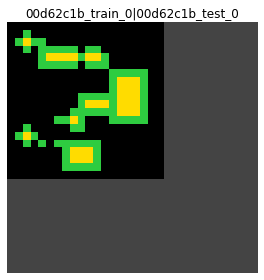

In [194]:
idx = next(i for i, s in enumerate(combined_test_set['ltest']) if s.endswith('00d62c1b_test_0'))
gsb_grid_mask = np.tile(coords,(32,32,1,1))
g = combined_test_set['gtest'][idx][1][1].copy() # [encoder/decoder][start/end]
g = np.expand_dims(g, 2)
dist = np.linalg.norm(gsb_grid_mask - g, axis=3)
recovered = np.argmin(dist, axis=2)
print(recovered)
plot_grid(recovered, combined_test_set['ltest'][idx])

[[ 0  0  0 ... 10 10 10]
 [ 0  0  0 ... 10 10 10]
 [ 0  0  2 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


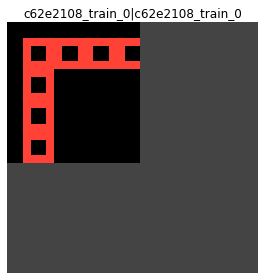

In [199]:
idx = next(i for i, s in enumerate(combined_train_set['ltrain']) if s.startswith('c62e2108_train_0'))
gsb_grid_mask = np.tile(coords,(32,32,1,1))
g = combined_train_set['gtrain'][idx][0][1].copy()
g = np.expand_dims(g, 2)
dist = np.linalg.norm(gsb_grid_mask - g, axis=3)
recovered = np.argmin(dist, axis=2)
print(recovered)
plot_grid(recovered, combined_train_set['ltrain'][idx])